## Introduction

This tutorial demonstrates how to use Deep Learning Recommendation Model (DLRM) to effectively
learn relationship between movies and ratings using DotInteraction

The Deep Learning Recommendation Model (DLRM) architecture is designed for more effective
learning of explicit and bounded-degree features. It comprises three main
components: an input layer (typically an embedding layer), a dot interaction layer for
modeling explicit feature interactions, and a deep network for capturing implicit interactions.

The dot interaction layer is the core of the DLRM, which computes the pairwise dot products between different feature embeddings.

The deep network is a standard feedforward multilayer perceptron
(MLP). These two networks are then combined to form the DLRM.

Now that we know a little bit about DLRM, let's start writing some code. We will
first train a DLRM on a real-world dataset, and demonstrate that the model has indeed
learnt important feature crosses.

Let's set the backend to JAX, and get our imports sorted.

In [ ]:
!pip install  jax_tpu_embedding keras-rs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.3/90.3 kB 5.2 MB/s eta 0:00:00


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # `"tensorflow"`/`"torch"`

import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from mpl_toolkits.axes_grid1 import make_axes_locatable

import keras_rs

Let's also define variables which will be reused throughout the example.

In [ ]:
MOVIELENS_CONFIG = {
    # features
    "int_features": [
        "movie_id",
        "user_id",
        "user_gender",
        "bucketized_user_age",
    ],
    "str_features": [
        "user_zip_code",
        "user_occupation_text",
    ],
    # model
    "embedding_dim": 8,
    "deep_net_num_units": [192, 192, 192],
    # training
    "learning_rate": 1e-2,
    "num_epochs": 25,
    "batch_size": 8192,
}


Here, we define a helper function for visualising weights of the cross layer in
order to better understand its functioning. Also, we define a function for
compiling, training and evaluating a given model.

In [ ]:
def plot_training_metrics(history):
    """Graphs all metrics tracked in the history object."""
    plt.figure(figsize=(12, 6))

    for metric_name, metric_values in history.history.items():
        plt.plot(metric_values, label=metric_name.replace('_', ' ').title())

    plt.title('Metrics over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(True)

def visualize_layer(matrix, features, cmap=plt.cm.Blues):
    plt.figure(figsize=(9, 9))

    im = plt.matshow(matrix, cmap=cmap)

    ax = plt.gca()
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    cax.tick_params(labelsize=10)

    # Set tick locations explicitly before setting labels
    ax.set_xticks(np.arange(len(features)))
    ax.set_yticks(np.arange(len(features)))

    ax.set_xticklabels(features, rotation=45, fontsize=5)
    ax.set_yticklabels(features, fontsize=5)

    plt.show()


def train_and_evaluate(
    learning_rate,
    epochs,
    train_data,
    test_data,
    model,
    plot_metrics=False,
):
    optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    loss = keras.losses.MeanSquaredError()
    rmse = keras.metrics.RootMeanSquaredError()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[rmse],
    )

    history = model.fit(
        train_data,
        epochs=epochs,
        verbose=1,
    )
    if plot_metrics:
      plot_training_metrics(history)

    results = model.evaluate(test_data, return_dict=True, verbose=1)
    rmse_value = results["root_mean_squared_error"]

    return rmse_value, model.count_params()


def print_stats(rmse_list, num_params, model_name):
    # Report metrics.
    num_trials = len(rmse_list)
    avg_rmse = np.mean(rmse_list)
    std_rmse = np.std(rmse_list)

    if num_trials == 1:
        print(f"{model_name}: RMSE = {avg_rmse}; #params = {num_params}")
    else:
        print(f"{model_name}: RMSE = {avg_rmse} ± {std_rmse}; #params = {num_params}")

## Real-world example

Let's use the MovieLens 100K dataset. This dataset is used to train models to
predict users' movie ratings, based on user-related features and movie-related
features.

### Preparing the dataset

The dataset processing steps here are similar to what's given in the
[basic ranking](/keras_rs/examples/basic_ranking/)
tutorial. Let's load the dataset, and keep only the useful columns.

In [ ]:
ratings_ds = tfds.load("movielens/100k-ratings", split="train")
ratings_ds = ratings_ds.map(
    lambda x: (
        {
            "movie_id": int(x["movie_id"]),
            "user_id": int(x["user_id"]),
            "user_gender": int(x["user_gender"]),
            "user_zip_code": x["user_zip_code"],
            "user_occupation_text": x["user_occupation_text"],
            "bucketized_user_age": int(x["bucketized_user_age"]),
        },
        x["user_rating"],  # label
    )
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/movielens/100k-ratings/incomplete.S3UIO5_0.1.1/movielens-train.tfrecord*..…

Dataset movielens downloaded and prepared to /root/tensorflow_datasets/movielens/100k-ratings/0.1.1. Subsequent calls will reuse this data.


For every feature, let's get the list of unique values, i.e., vocabulary, so
that we can use that for the embedding layer.

In [ ]:
vocabularies = {}
for feature_name in MOVIELENS_CONFIG["int_features"] + MOVIELENS_CONFIG["str_features"]:
    vocabulary = ratings_ds.batch(10_000).map(lambda x, y: x[feature_name])
    vocabularies[feature_name] = np.unique(np.concatenate(list(vocabulary)))

One thing we need to do is to use `keras.layers.StringLookup` and
`keras.layers.IntegerLookup` to convert all features into indices, which can
then be fed into embedding layers.

In [ ]:
lookup_layers = {}
lookup_layers.update(
    {
        feature: keras.layers.IntegerLookup(vocabulary=vocabularies[feature])
        for feature in MOVIELENS_CONFIG["int_features"]
    }
)
lookup_layers.update(
    {
        feature: keras.layers.StringLookup(vocabulary=vocabularies[feature])
        for feature in MOVIELENS_CONFIG["str_features"]
    }
)

ratings_ds = ratings_ds.map(
    lambda x, y: (
        {
            feature_name: lookup_layers[feature_name](x[feature_name])
            for feature_name in vocabularies
        },
        y,
    )
)

Let's split our data into train and test sets. We also use `cache()` and
`prefetch()` for better performance.

In [ ]:
ratings_ds = ratings_ds.shuffle(100_000)

train_ds = (
    ratings_ds.take(80_000)
    .batch(MOVIELENS_CONFIG["batch_size"])
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)
test_ds = (
    ratings_ds.skip(80_000)
    .batch(MOVIELENS_CONFIG["batch_size"])
    .take(20_000)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

### Building the model

The model will have embedding layers, followed by DotInteraction and feedforward
layers.

In [ ]:
class DLRM(keras.Model):
    def __init__(
        self,
        dense_num_units_lst,
        embedding_dim=MOVIELENS_CONFIG["embedding_dim"],
        **kwargs,
    ):
        super().__init__(**kwargs)

        # Layers.

        self.embedding_layers = []
        for feature_name, vocabulary in vocabularies.items():
            self.embedding_layers.append(
                keras.layers.Embedding(
                    input_dim=len(vocabulary) + 1,
                    output_dim=embedding_dim,
                )
            )

        self.dot_layer = keras_rs.layers.DotInteraction()

        self.dense_layers = []
        for num_units in dense_num_units_lst:
            self.dense_layers.append(keras.layers.Dense(num_units, activation="relu"))

        self.output_layer = keras.layers.Dense(1)

        # Attributes.
        self.dense_num_units_lst = dense_num_units_lst
        self.embedding_dim = embedding_dim

    def call(self, inputs):
        embeddings = []
        for feature_name, embedding_layer in zip(vocabularies, self.embedding_layers):
            embeddings.append(embedding_layer(inputs[feature_name]))

        # Pass the list of embeddings to the DotInteraction layer
        x = self.dot_layer(embeddings)

        for dense_layer in self.dense_layers:
            x = dense_layer(x)

        x = self.output_layer(x)

        return x

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 8.1493 - root_mean_squared_error: 2.8203
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.8909 - root_mean_squared_error: 1.6905
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5062 - root_mean_squared_error: 1.2266
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2285 - root_mean_squared_error: 1.1076
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9398 - root_mean_squared_error: 0.9694 
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8562 - root_mean_squared_error: 0.9253
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7850 - root_mean_squared_error: 0.8860
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7260 - root_mean_squared_error: 0.8520 
Epoch 9/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6800 - root_mean_squared_error: 0.8246 
Epoch 10/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6444 - root_mean_squared_error: 0.8028
Epoch 

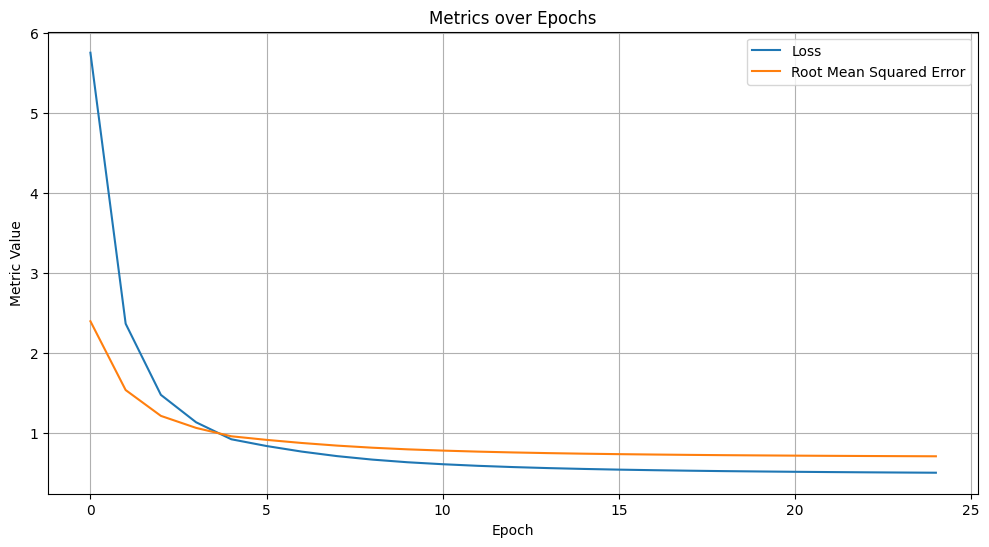

In [ ]:
dot_network = DLRM(
    dense_num_units_lst=MOVIELENS_CONFIG["deep_net_num_units"],
    embedding_dim=MOVIELENS_CONFIG["embedding_dim"],
)
rmse, dot_network_num_params = train_and_evaluate(
    learning_rate=MOVIELENS_CONFIG["learning_rate"],
    epochs=MOVIELENS_CONFIG["num_epochs"],
    train_data=train_ds,
    test_data=test_ds,
    model= dot_network,
    plot_metrics=True
)
print_stats(
    rmse_list=[rmse],
    num_params=dot_network_num_params,
    model_name="Dot Network",
)


### Visualizing feature interactions

The DotInteraction layer itself doesn't have a conventional "weight" matrix like a Dense layer. Instead, its function is to compute the dot product between the embedding vectors of your features.

To visualize the strength of these interactions, we can calculate a matrix representing the pairwise interaction strength between all feature embeddings. A common way to do this is to take the dot product of the embedding matrices for each pair of features and then aggregate the result into a single value (like the mean of the absolute values) that represents the overall interaction strength.

In [ ]:
def get_dot_interaction_matrix(model, feature_names):
    # Extract the trained embedding weights from the model
    embedding_weights = [layer.get_weights()[0] for layer in model.embedding_layers]

    num_features = len(feature_names)
    interaction_matrix = np.zeros((num_features, num_features))

    # Iterate through each pair of features to calculate their interaction strength
    for i in range(num_features):
        for j in range(num_features):
            # Calculate the dot product between the two embedding matrices
            interaction = np.dot(embedding_weights[i], embedding_weights[j].T)
            # Take the mean of the absolute values as a measure of interaction strength
            interaction_strength = np.mean(np.abs(interaction))
            interaction_matrix[i, j] = interaction_strength

    return interaction_matrix


Visualizing the feature interaction strengths:


<Figure size 900x900 with 0 Axes>

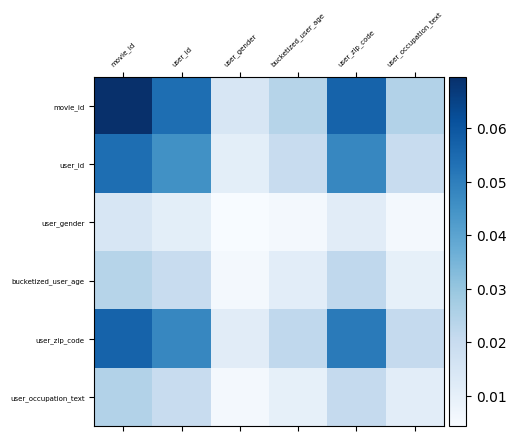

In [ ]:
# Get the list of feature names in the correct order
feature_names = list(vocabularies.keys())

# Calculate the interaction matrix
interaction_matrix = get_dot_interaction_matrix(dot_network, feature_names)

# Visualize the matrix as a heatmap
print("\nVisualizing the feature interaction strengths:")
visualize_layer(interaction_matrix, feature_names)

In [ ]:
dlrm_rmse_list = []

for _ in range(20):

    dot_network = DLRM(
        dense_num_units_lst=MOVIELENS_CONFIG["deep_net_num_units"],
        embedding_dim=MOVIELENS_CONFIG["embedding_dim"],
    )
    rmse, dot_network_num_params = train_and_evaluate(
        learning_rate=MOVIELENS_CONFIG["learning_rate"],
        epochs=MOVIELENS_CONFIG["num_epochs"],
        train_data=train_ds,
        test_data=test_ds,
        model= dot_network,
    )
    dlrm_rmse_list.append(rmse)

print_stats(
    rmse_list=dlrm_rmse_list,
    num_params=dot_network_num_params,
    model_name="Dot Network",
)



In [ ]:
def plot_rmse(rmse_list, model_name):
  plt.figure()
  plt.plot(rmse_list)
  plt.title(f'RMSE over trials for {model_name}')
  plt.xlabel('Trial')
  plt.ylabel('RMSE')
  plt.show()

plot_rmse(dlrm_rmse_list, "Dot Network")